## VC + OS, one-stage

In [1]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from numpy import loadtxt
from numpy import sort
from numpy import mean
from sklearn.metrics import cohen_kappa_score
#from autoimpute.imputations import MultipleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.impute import SimpleImputer 
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from collections import Counter
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor

In [2]:
df = pd.read_excel("Updated_UKBioBank.xlsx")
## Data Pre-processing

In [3]:
# specific to UK BioBank dataset
class PreProcessing:
    def __init__(self, df):
        self.df = df
        
    def cleaning(self):
        new_df = self.df.copy()
        new_df = new_df.iloc[:, new_df.columns != 'QTrest']
        new_df = new_df[~((new_df['AF']==1) & (new_df['Arr']==1))] # remove overlaps
        imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        new_df = pd.DataFrame(imp.fit_transform(new_df), columns=new_df.columns)
        new_df.loc[(new_df['Arr'] == 0) & (new_df['AF'] == 0), 'Category'] = 0
        new_df.loc[(new_df['Arr'] == 0) & (new_df['AF'] == 1), 'Category'] = 1
        new_df.loc[(new_df['Arr'] == 1) & (new_df['AF'] == 0), 'Category'] = 2
        self.df = new_df
        return self.df
    
    def getTrainTestSet(self):
        new_df = self.cleaning()
        choosing_samples_AF = new_df[new_df['AF'] == 1]
        choosing_samples_Arr =  new_df[new_df['Arr'] == 1]
        healthy_samples = new_df[new_df['Category'] == 0]
        
        AF_x = choosing_samples_AF.loc[:,choosing_samples_AF.columns != 'Category']
        AF_y = choosing_samples_AF['Category']
        
        Arr_x = choosing_samples_Arr.loc[:,choosing_samples_Arr.columns != 'Category']
        Arr_y = choosing_samples_Arr['Category']
        
        healthy_x = healthy_samples.loc[:,healthy_samples.columns != 'Category']
        healthy_y = healthy_samples['Category']
        
        
        AF_X_train, AF_X_test, AF_y_train, AF_y_test = train_test_split(AF_x, AF_y, test_size=0.1)
        Arr_X_train, Arr_X_test, Arr_y_train, Arr_y_test = train_test_split(Arr_x, Arr_y, test_size=0.1)
        healthy_X_train, healthy_X_test, healthy_y_train, healthy_y_test = train_test_split(healthy_x, healthy_y, test_size=0.01)
        
        X_test_df = pd.concat([AF_X_test,Arr_X_test,healthy_X_test])
        y_test_df = pd.concat([AF_y_test,Arr_y_test,healthy_y_test])
        X_train_df = pd.concat([AF_X_train,Arr_X_train,healthy_X_train])
        y_train_df = pd.concat([AF_y_train,Arr_y_train,healthy_y_train])
        X_train_df['Category'] = y_train_df
        X_test_df['Category'] = y_test_df
        self.df = X_train_df
        return self.df, X_test_df
    
    # remving outliers using Isolation Forest
    def OutlierRemoval(self):
        new_df, X_test_df = self.getTrainTestSet()
        new_df_healthy = new_df[new_df['Category'] == 0]
        new_df_disease = new_df[(new_df['Category'] == 1)|(new_df['Category'] == 2)]
        for_outlier_x = new_df_healthy.loc[:, ~new_df_healthy.columns.isin(['eid','AF', 'Arr', 'Category'])]
        for_outlier_y = new_df_healthy['Category']
        clf = LocalOutlierFactor(n_neighbors=2)
        for_outlier_y_pred = clf.fit_predict(for_outlier_x)
        for_outlier_x['outlier_score'] = for_outlier_y_pred
        for_outlier_x['Category'] = for_outlier_y
        for_outlier_x['eid'] = new_df_healthy['eid']
        for_outlier_x['Arr'] = new_df_healthy['Arr']
        for_outlier_x['AF'] = new_df_healthy['AF']
        without_outliers = for_outlier_x[for_outlier_x['outlier_score'] == 1]
        without_outliers = without_outliers.loc[:,without_outliers.columns != 'outlier_score']
        df1 = new_df_healthy.copy()
        df1 = new_df_healthy.set_index('eid')
        df2 = without_outliers.copy()
        df2 = without_outliers.set_index('eid')
        final_healthy_df = pd.merge(df1, df2, how='inner')
        final_healthy_df['eid'] = df2.index
        final_df = pd.concat([final_healthy_df, new_df_disease])
        self.df = final_df
        return self.df, X_test_df
    
    def DataAugmentation(self):
        new_df, X_test_df = self.getTrainTestSet()
        healthy_df = new_df[new_df['Category'] == 0]
        AF_data = new_df.drop(columns=['Arr'], axis=1) # data with only the AF label
        Arr_data = new_df.drop(columns=['AF'], axis=1) # data with only the Arr label
        
        arr_x = Arr_data.loc[:,Arr_data.columns != 'Arr']
        arr_y = Arr_data['Arr']

        oversample_arr = RandomOverSampler(random_state=42, sampling_strategy=0.8)
        arr_x, arr_y = oversample_arr.fit_resample(arr_x, arr_y)
        
        af_x = AF_data.loc[:,AF_data.columns != 'AF']
        af_y = AF_data['AF']

        oversample_af = RandomOverSampler(random_state=42, sampling_strategy=0.8)
        af_x, af_y = oversample_arr.fit_resample(af_x, af_y)
    
        arr_x['Arr'] = arr_y
        af_x['AF'] = af_y

        AF_only = af_x[af_x['AF'] == 1] # data with only positive labels of AF
        Arr_only = arr_x[arr_x['Arr'] ==1] # data with only positive labels of Arr
        with_oversample_df = pd.concat([AF_only, Arr_only,healthy_df])
        
        with_oversample_df.loc[(with_oversample_df['Arr'].isnull()) & (with_oversample_df['AF'] == 1), 'Arr'] = 0
        with_oversample_df.loc[(with_oversample_df['AF'].isnull()) & (with_oversample_df['Arr'] == 1), 'AF'] = 0
        
        with_oversample_df.loc[(with_oversample_df['Arr'] == 0) & (with_oversample_df['AF'] == 0), 'Category'] = 0
        with_oversample_df.loc[(with_oversample_df['Arr'] == 0) & (with_oversample_df['AF'] == 1), 'Category'] = 1
        with_oversample_df.loc[(with_oversample_df['Arr'] == 1) & (with_oversample_df['AF'] == 0), 'Category'] = 2
        self.df = with_oversample_df
        return self.df, X_test_df
    def finalCleanedDf(self):
        new_df, X_test_df = self.DataAugmentation()
        new_df.loc[(new_df['Arr'] == 1) & (new_df['Category'] == 2), 'AF'] = 0
        new_df.loc[(new_df['AF'] == 1) & (new_df['Category'] == 1), 'Arr'] = 0
        self.df = new_df
        return self.df, X_test_df

In [4]:
instance = PreProcessing(df)
train_df, test_df= instance.finalCleanedDf()

In [5]:
train_df['Category'].value_counts()

0.0    51530
2.0    42434
1.0    41340
Name: Category, dtype: int64

In [6]:
test_df['Category'].value_counts()

0.0    521
1.0    169
2.0     17
Name: Category, dtype: int64

In [7]:
test_df['Arr'].value_counts()

0.0    690
1.0     17
Name: Arr, dtype: int64

In [8]:
X_train = train_df.drop(columns=['eid', 'AF', 'Arr', 'Category'])
y_train = train_df['Category']


X_test = test_df.drop(columns=['eid', 'AF', 'Arr', 'Category'])
y_test = test_df['Category']

In [9]:
estimators = []

model1 = xgb.XGBClassifier(objective='multi:softmax', subsample=0.75,  
                          n_estimators=100, colsample_bytree = 0.99, learning_rate = 1,
                max_depth = 10,  gamma=5, alpha = 1, seed=123, use_label_encoder=False, eval_metric='error')

estimators.append(('XGBoost', model1))
estimators.append(('bayes', GaussianNB()))
estimators.append(('GradientDescent' , SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=500)))
ensemble = VotingClassifier(estimators, voting = 'soft')

In [10]:
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [11]:
y_train.value_counts()

0.0    51530
2.0    42434
1.0    41340
Name: Category, dtype: int64

In [12]:
Counter(y_pred)

Counter({0.0: 557, 1.0: 149, 2.0: 1})

In [13]:
y_test.value_counts()

0.0    521
1.0    169
2.0     17
Name: Category, dtype: int64

In [14]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

In [15]:
cm

array([[449,  71,   1],
       [ 95,  74,   0],
       [ 13,   4,   0]], dtype=int64)

In [16]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Healthy','AF','Arr'], 
                     columns = ['Healthy','AF','Arr'])

In [17]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred, average='macro')
print('f1_score: %.3f' % f1_score)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %.3f' % recall)

f1_score: 0.433
Precision: 0.434
Recall: 0.433


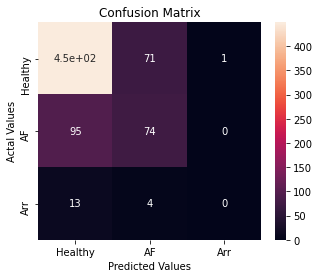

In [18]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       521
         1.0       0.50      0.44      0.47       169
         2.0       0.00      0.00      0.00        17

    accuracy                           0.74       707
   macro avg       0.43      0.43      0.43       707
weighted avg       0.71      0.74      0.73       707

